# Long-range correlation and fractal dynamics in C. elegans: changes with aging and stress

## Libraries and Settings

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [308]:
import sys
import os
import pathlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.stats import norm
from scipy import stats
import matplotlib.mlab as mlab
import statsmodels.api as sm
import matplotlib as mpl
import statsmodels.stats.multitest as smm
import matplotlib.ticker as plticker
import random
from scipy import optimize
from matplotlib import ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [309]:
# Locals
from modules.functions import *

In [4]:
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['xtick.minor.pad'] = 10
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['ytick.minor.pad'] = 10
plt.rcParams['xtick.direction']="in"
plt.rcParams['ytick.direction']="in"
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True


sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
sns.set_style({"xtick.direction": "in",
               "ytick.direction": "in",
               'xtick.color': 'black',
               'ytick.color': 'black',
               'text.color': 'black',
               'axes.edgecolor': 'black',
               'axes.labelcolor': 'black',
               'text.color': 'black'})


# Functions

In [13]:
def increase_font(ax, fontsize=18):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

def datainfo():
    print("Aging data set summary")
    print("\n")
    summary=[]
    for age in [1,2,3,4,5,6]:
        sample_dir=pathlib.Path('../data/age/{}'.format(age))
        tracks=[i for i in sample_dir.glob('*')]
        summary.append([age,len(tracks)])
        
    print(pd.DataFrame(summary,columns=["Age","# tracks"]))
     
    print("\n")
    summary=[]
    for t in [15,20,25]:
        sample_dir=pathlib.Path('../data/temperature/{}'.format(t))
        tracks=[i for i in sample_dir.glob('*')]
        summary.append([t,len(tracks)])
        
    print("Temperature data set summary\n")
        
    print(pd.DataFrame(summary,columns=["Temperature","# tracks"]))
    

def read_tracks(tracks):
    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)

    len_max=max([len(x) for x in df_tracks])

    df_x=pd.DataFrame()
    for i,df in enumerate(df_tracks):
        x=np.array(df["x"])
        x=np.array(x-x[0])
        x0=np.zeros(len_max-len(x))
        x=np.concatenate((x,x0), axis=0)
        df_x[i]=x


    df_y=pd.DataFrame()
    for i,df in enumerate(df_tracks):
        y=np.array(df["y"])
        y=np.array(y-y[0])
        y0=np.zeros(len_max-len(y))
        y=np.concatenate((y,y0), axis=0)
        df_y[i]=y
    return df_x,df_y

def msd(df_x,df_y):
    variance=[np.nanvar(df_x.T[t])+np.nanvar(df_y.T[t]) for t in range(0,len(df_y))]
    return variance

def msd_by_age(age):
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    
    df_x,df_y=read_tracks(tracks)
        
    variance=msd(df_x,df_y)
    
    var_df=pd.DataFrame(np.transpose([np.arange(0,len(df_y))/5,variance]),columns=["time","variance"])
    var_df.to_csv("../results/msd_age-{}.csv".format(age))


def piecewise_linear(x, x0, y0, k1):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:y0])

def line(x, a, b):
    return a * x + b

def winm(x, y, nw):
    xw = []
    yw = []
    step = (max(x) - min(x)) / nw
    lw = [min(x) + step * i for i in range(0, nw)]
    for i in range(0, len(lw) - 1):
        if len(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]) > 0:
            xw.append(np.mean(x[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
            yw.append(np.mean(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
    return (xw, yw)

def read_dataset(dataset,label):
    """label can be age or temperature, this is, 1,2,3,4,5,6 or 15,20,25"""
    if dataset=="age":
        sample_dir=pathlib.Path('../data/age/{}'.format(label))
    else:
        sample_dir=pathlib.Path('../data/temperature/{}'.format(label))
    tracks=[i for i in sample_dir.glob('*')]
    df_x,df_y=read_tracks(tracks)
    return df_x,df_y

def slope_random_sample(df_x,df_y):
    randomsample=list(np.random.choice(list(df_x.columns),df_x.shape[1]))
    ndf_x=df_x[randomsample]
    ndf_y=df_x[randomsample]

    variance=msd(ndf_x,ndf_y)
    var_df=pd.DataFrame(np.transpose([np.arange(0,len(ndf_y))/5,variance]),
                        columns=["time","variance"])
    y=np.log10(var_df['variance'].tolist()[1:])
    x=np.log10(var_df["time"].tolist()[1:])

    xw, yw=winm(x,y,200)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) 
    return(p[-1])
    

# Data summary

In [5]:
datainfo()

Aging data set summary


   Age  # tracks
0    1       244
1    2       190
2    3       162
3    4       198
4    5       224
5    6        66


Temperature data set summary

   Temperature  # tracks
0           15        67
1           20        48
2           25        64


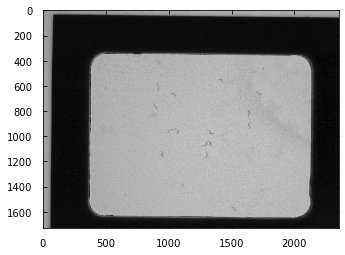

In [61]:
figpath="../data/20151026_132836-copper-15worms-N2-day1-standard-c3600170.png"

import matplotlib.image as mpimg
image = mpimg.imread(figpath)
plt.imshow(image, cmap='gray')

plt.show()


In [67]:
figpath="../data/track.pdf"
from IPython.display import IFrame
IFrame(figpath, width=600, height=400)

# Aging data set

## Mean Square Displacement

In [6]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [7]:
df_x,df_y=read_tracks(tracks)
variance=msd(df_x,df_y)

In [8]:
var_df=pd.DataFrame(np.transpose([np.arange(0,len(df_y))/5,variance]),columns=["time","variance"])
var_df.to_csv("../results/msd_age-{}.csv".format(age))
var_df.head()

,time,variance
0,0.0,0.000000
1,0.2,0.000118
2,0.4,0.000722
3,0.6,0.001861
4,0.8,0.003194


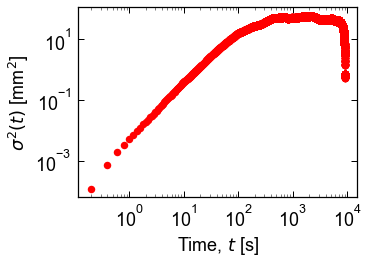

In [120]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
         ylabel="$\sigma^2(t)$ [mm$^2$]")

ax.loglog(np.arange(0,len(df_y))/5,variance, ".r",markersize=15)

increase_font(ax,fontsize=18)

In [10]:
#for age in [1,2,3,4,5,6]:
#    msd_by_age(age)

In [11]:
msd_aging=pd.DataFrame()
age=1
df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
msd_aging['time']=df['time']
for age in [1,2,3,4,5,6]:
    df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
    msd_aging[str(age)]=df['variance']

[ 2.24955812  1.6530972   1.70285396]
[ 0.01200987  0.01016612  0.014524  ]


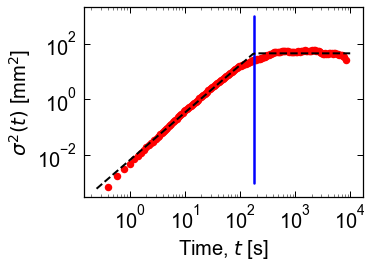

[ 2.52711639  1.45963527  1.59739281]
[ 0.01566148  0.01385582  0.01511838]


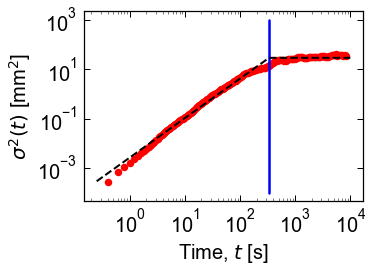

[ 2.41769507  1.5263808   1.69256481]
[ 0.01185721  0.0105962   0.01293123]


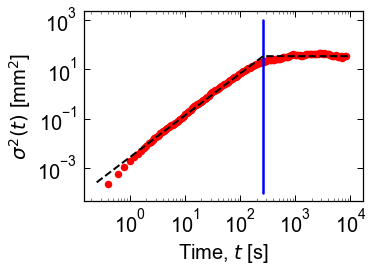

[ 2.31520528  1.69634574  1.65232543]
[ 0.01457774  0.0123266   0.01645663]


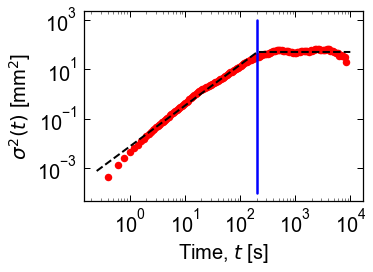

[ 2.36308505  1.63747631  1.67231308]
[ 0.01546792  0.01346711  0.0171887 ]


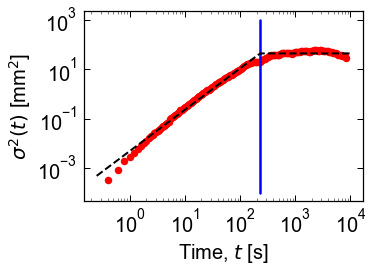

[ 2.41632597  1.6540787   1.61540052]
[ 0.02039047  0.01740241  0.02123729]


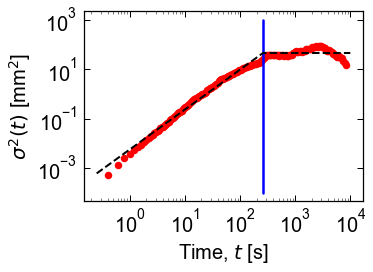

In [121]:
exp=[]
experror=[]
minb=np.array([np.nan,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])/1000
for i in [1,2,3,4,5,6]:
    y=np.log10(msd_aging[str(i)].tolist()[1:])
    x=np.log10(msd_aging["time"].tolist()[1:])
    
    xw, yw=winm(x,y,200)
    xw2, yw2=winm(x,y,1000)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) #x0, y0, k1
    print(p)
    exp.append(p[2])
    experror.append(np.sqrt(np.diag(pcov))[2])

    print(np.sqrt(np.diag(pcov)))
    xd = np.linspace(-0.6, 4, 100)
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
             ylabel="$\sigma^2(t)$ [mm$^2$]")
    locy = plticker.MultipleLocator(base=1^10) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    

    ax.loglog(10**np.array(xw),10**np.array(yw), ".r",markersize=15)
    ax.loglog([10**p[0],10**p[0]],[minb[i],10**3],"-b",linewidth=2.5)
    ax.loglog(10**xd, 10**piecewise_linear(xd, *p),"--k",linewidth=2)

    increase_font(ax,fontsize=20)
    plt.savefig("../results/msd_age_"+str(i)+".pdf",bbox_inches='tight')
    plt.show()

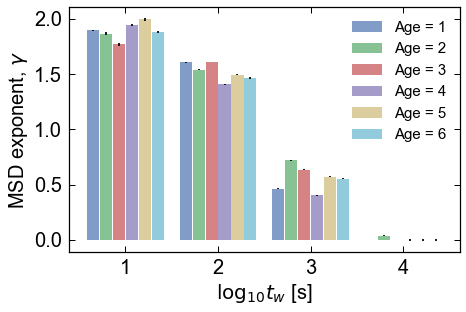

In [206]:
fig, ax = plt.subplots(figsize=(7,4.5))
ax = plt.subplot(111, xlabel="$\log_{10} t_w$ [s]", 
         ylabel="MSD exponent, $\gamma$")

ind = np.arange(4)  # the x locations for the groups
width = 0.13# the width of the bars
ax.set_xticks(ind + 3*(width+0.03))
step=0
for i in range(1,7,1):
   
    df=msd_aging[["time",str(i)]].copy()
    df=df.apply(np.log10)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna()


    experror=[]
    result=[]
    for w in np.arange(1,5,1):
        df2=df[df.time<w].copy()
        if w==0:
            df2=df2
        else:
            df2=df2[df2.time>w-1]

        y=df2[str(i)].tolist()
        x=df2["time"].tolist()

        param_bounds=([0,-np.inf],[2,np.inf])
        popt, pcov = optimize.curve_fit(line, x, y,bounds=param_bounds) 
        result.append([w+i/10,popt[0]])
        experror.append(np.sqrt(np.diag(pcov))[0])


    yerr=np.asarray(experror)
    exp_means=[result[k][1] for k in range(0,4)]


    ax.bar(ind + width+step, exp_means, width, yerr=yerr,alpha=0.7,label="Age = "+str(i))
    step=step+ width+0.01




ax.set_xticklabels(('1', '2', '3', '4','5'))
locy = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)

ax.legend(fontsize=15) 
increase_font(ax,fontsize=20)
plt.savefig("../results/msd_aging_fit.pdf",bbox_inches='tight')

### Bootstrapping


In [29]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [ ]:
data_plot=[]
for age in [1,2,3,4,5,6]:
    df_x,df_y=read_dataset("age",age)
    slope_bootstrapping=[]
    for i in range(0,100):
        print(age,i)
        slope=slope_random_sample(df_x,df_y)
        slope_bootstrapping.append(slope)
    data_plot.append(slope_bootstrapping)

data_plot = pd.DataFrame(data_plot)
data_plot.to_csv('../results/aging_msd_bootstrapping.csv', index=False, header=False)

### Two-sample test

In [ ]:
def box_plot_age(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9,4.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

#     ax.set_ylim(bottom_limit,1.0)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel('MSD exponent, $\gamma$')
    increase_font(ax,18)

def matrix_plot(conf_arr):
    conf_arr=np.array(conf_arr)


    fig = plt.figure(figsize=(10, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=14)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = '123456'
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Age [days]',fontsize=18)
    ax.set_ylabel('Age [days]',fontsize=18)
    ax.tick_params(labelsize=18)

In [ ]:
box_plot_age(data_plot)

In [ ]:
indexes=[]
new_p_age=[]
for j in range(0,6):
    for i in range(0,6):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        if i <j:
            new_p_age.append(pvalue)
            indexes.append((i, j))


# Plot p-values with correction for multiple testing    
a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

p_array = np.ones((6, 6))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[1,2,3,4,5,6]
p = pd.DataFrame(p_array, index=ak, columns=ak)

p = p.loc[:6, :6]

In [ ]:
matrix_plot(p)

## Fractal dimension

In [14]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [125]:
df=df_tracks[2]

series="mov_forward"

In [126]:
df.head()

,time,x,y,speed,head_speed,mov_forward
4488,1800.0,19.699461,12.621270,0.053505,0.025913,1.0
4489,1800.2,19.701749,12.609876,0.054729,0.008638,1.0
4490,1800.4,19.703686,12.597512,0.058934,0.095015,1.0
4491,1800.6,19.706122,12.575807,0.102853,0.017276,1.0
4492,1800.8,19.707186,12.562289,0.063857,0.025913,1.0


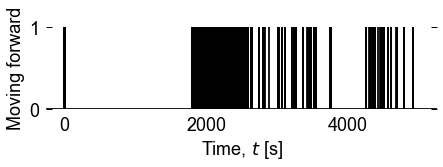

In [127]:
names=["Moving forward"]
fontsize=20
for k in range(0,len(names)):
    gs = gridspec.GridSpec(1,1)
    fig = plt.figure(figsize=(7,1.5))
    
    ax0 = fig.add_subplot(gs[0,0])
    x=np.array(df[["time"]][df.time<5000]).ravel()
    y1=np.array(df[["mov_forward"]][df.time<5000]).ravel()
    ax0.vlines(x, 0, y1, colors='k', linestyles='solid')
    ax0.acorr(x,color='k')
        
    ax0.set_ylim(0,1)
    #ax0.set_xlim(0,2000)
    ax0.locator_params(axis='x',nbins=5)
    ax0.locator_params(axis='y',nbins=1)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    
    ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    
    
    plt.ylabel("Moving forward") ; plt.xlabel('Time, $t$ [s]') ;

    increase_font(ax0,18)
    

In [ ]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df,std_err)
fractal_plot(r,N,A,Df,drop_first_points,drop_last_points,series)
plt.show()

In [ ]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df)

In [ ]:
age=1
for age in [1,2,3,4,5,6]:
    print(age)
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]

    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)

    fd_exp=[]
    for track in df_tracks:
        df=track
        series="mov_forward"
        eventtimes = timeseriestoeventtimes(df, series)
        if sum(eventtimes) > 0:
            r, N = nbox_boxsize(eventtimes, number_of_sizes=20)
            if sum(N) > 0:
                list_df, error_df = find_stable_slope(r, N, 3)
                drop_last_points = -(len(np.array(list_df)[np.array(list_df) < 0.1]) + 1)
                drop_first_points = 0
                Df, A, r_value, p_value, std_err = fit_data(
                    r[drop_first_points:drop_last_points],
                    N[drop_first_points:drop_last_points])
                if len(r) > abs(drop_last_points):
                    fd_exp.append(Df)

    data_plot = pd.DataFrame(fd_exp)
    data_plot.to_csv('../results/fd_exp-{}.csv'.format(age), index=False, header=False)


In [103]:
df_aging=pd.DataFrame()

for age in [1,2,3,4,5,6]:
    df=pd.read_csv('../results/fd_exp-{}.csv'.format(age),names=[age])
    df_aging[age]=df[age]

In [247]:
def box_plot_age(data_to_plot,bottom_limit):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
#     ax.grid()
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(bottom_limit,1.1)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel('Fractal dimension, $d_f$')
    increase_font(ax,20)
    
def matrix_plot_age(conf_arr):
    conf_arr=np.array(conf_arr)

    fig = plt.figure(figsize=(6, 5))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest',vmin=0,vmax=1)

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=14)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = '123456'
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Age [days]',fontsize=20)
    ax.set_ylabel('Age [days]',fontsize=20)
    ax.tick_params(labelsize=20)
    

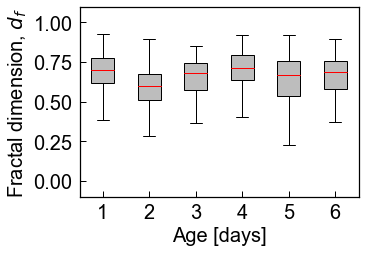

In [174]:
data_to_plot=[list(df_aging[x].dropna()) for x in list(df_aging.columns)]
box_plot_age(data_to_plot,-0.1)
plt.savefig('../results/age_fractal_d.pdf', bbox_inches='tight')

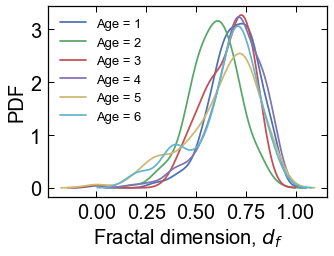

In [204]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(data_to_plot[age],hist=False, rug=False,label="Age = "+str(age+1))

    
ax.legend(fontsize=13) 
ax.set_xlabel('Fractal dimension, $d_f$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [176]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(data_to_plot[age], 'norm'))

KstestResult(statistic=0.64079596118161819, pvalue=0.0)
KstestResult(statistic=0.60741139594615468, pvalue=0.0)
KstestResult(statistic=0.64164459658193351, pvalue=0.0)
KstestResult(statistic=0.62774377929223735, pvalue=0.0)
KstestResult(statistic=0.56439400073631574, pvalue=0.0)
KstestResult(statistic=0.59568894619574675, pvalue=0.0)


In [188]:
st,pvalue=stats.ks_2samp(data_to_plot[1], data_to_plot[0])

In [245]:
import matplotlib as mpl
import statsmodels.stats.multitest as smm


indexes=[]
new_p_age=[]
for j in range(0,6):
    for i in range(0,6):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)
        if i <j:
            new_p_age.append(pvalue)
            indexes.append((i, j))

a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

p_array = np.ones((6, 6))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[1,2,3,4,5,6]
p = pd.DataFrame(p_array, index=ak, columns=ak)

p = p.loc[:6, :6]

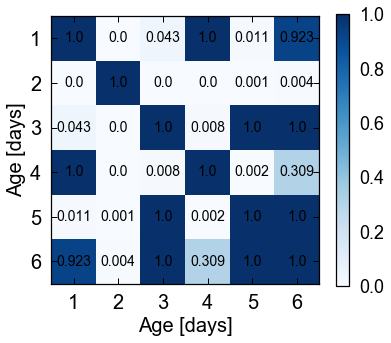

In [248]:
matrix_plot_age(np.array(p))

## DFA

In [207]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [209]:
df_tracks[0].head()

,time,x,y,speed,head_speed,mov_forward
8728,1800.0,7.460823,4.663983,0.059403,0.008879,1.0
8729,1800.2,7.468787,4.655871,0.055030,0.008879,1.0
8730,1800.4,7.476050,4.648023,0.051763,0.035518,1.0
8731,1800.6,7.487224,4.635142,0.082550,0.186469,1.0
8732,1800.8,7.494072,4.626237,0.054379,0.106554,1.0


In [225]:
for age in [1,2,3,4,5,6]:
    print(age)
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]

    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)
    for i in range(0,len(df_tracks)):
        track=df_tracks[i]
        y=np.array(track["speed"])
        df=dfa(y,order=1)
        df.to_csv("../results/dfa/speed-{}-{}.csv".format(age,i))
        track=df_tracks[i]
        y=np.array(track["head_speed"])
        df=dfa(y,order=1)
        df.to_csv("../results/dfa/head_speed-{}-{}.csv".format(age,i))

1
2
3
4
5
6


### Speed

In [296]:
dfa_tracks=[]
for age in [1,2,3,4,5,6]:
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/speed-{}-{}.csv".format(age,i))
        temp.append(df)
    dfa_tracks.append(temp)    

In [297]:
dfa_age_list=[pd.concat(dfa_tracks[age]) for age in [0,1,2,3,4,5]]

-2.716717220705364 0.9492029549110448 0.0201068846446


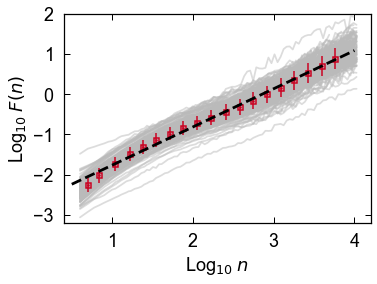

-2.8054812470532617 0.9162203054595471 0.0205734031484


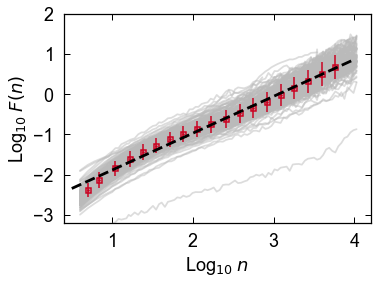

-2.7677411141532335 0.9383039066292889 0.0221102934512


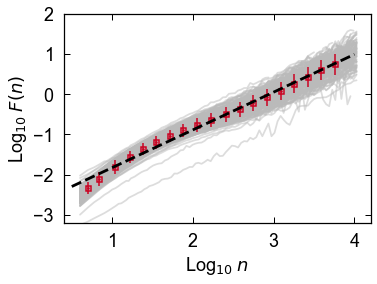

-2.7741040506661 0.9661908566432974 0.0214913573453


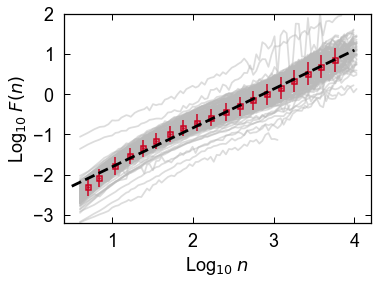

-2.8514397971211327 0.9543074590481191 0.0221234084174


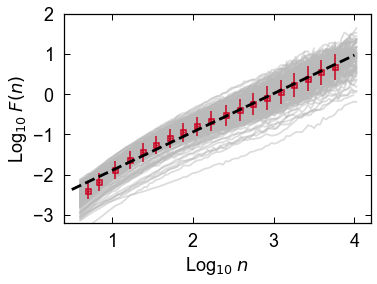

-2.9112086811902333 0.9615514049895666 0.0196013656713


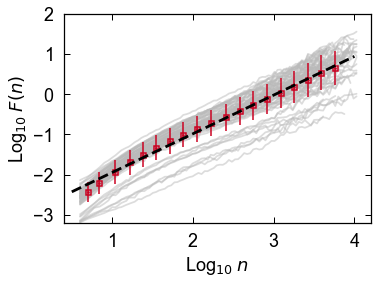

In [298]:
slope_age1=[]
slope_age_error1=[]
for age in range(0,6):
    dataf=dfa_age_list[age].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[:],fw[:])
    intercept, slope = result.params.tolist()
    slope_age1.append(slope)
    slope_age_error1.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5*1.1,3.5*1.1))


    for track in range(0,len(dfa_tracks[age])):
         ax.plot(dfa_tracks[age][track].n,dfa_tracks[age][track].F,color="#bababa",alpha=0.5)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')

    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_ylim(-3.2,2)

#     plt.savefig("../results/fractal_paper/manuscript/dfa/dfa_"+str(column)+"_"+str(age+1)+".pdf",bbox_inches='tight')
    plt.show()

In [233]:
age_list_slope=[]
for age in range(0,6,1):
    temp=[]
    for i in range(0,len(dfa_tracks[age])):
        result=linmodel_fit(dfa_tracks[age][i]["n"],dfa_tracks[age][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    age_list_slope.append(temp)

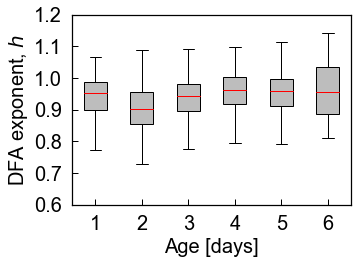

In [241]:
def box_plot_age(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(0.6,1.2)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel('DFA exponent, $h$')
    increase_font(ax,20)
    
box_plot_age(age_list_slope)


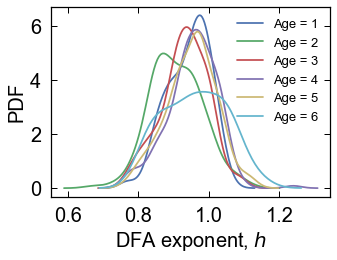

In [242]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(age_list_slope[age],hist=False, rug=False,label="Age = "+str(age+1))

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [243]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(age_list_slope[age], 'norm'))

KstestResult(statistic=0.77758808505867449, pvalue=0.0)
KstestResult(statistic=0.76156785346679257, pvalue=0.0)
KstestResult(statistic=0.77606423835374794, pvalue=0.0)
KstestResult(statistic=0.77619706197275185, pvalue=0.0)
KstestResult(statistic=0.77697443063240978, pvalue=0.0)
KstestResult(statistic=0.79094860516243937, pvalue=0.0)


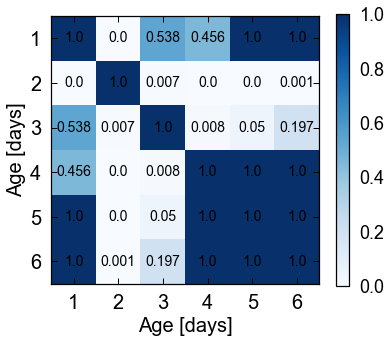

In [240]:
indexes=[]
new_p_age=[]
for j in range(0,6):
    for i in range(0,6):
        s1=[x for x in age_list_slope[j] if str(x) != 'nan']
        s2=[x for x in age_list_slope[i] if str(x) != 'nan']
        tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)

        if i <j:
            new_p_age.append(pvalue)
            indexes.append((i, j))


a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

p_array = np.ones((6, 6))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[1,2,3,4,5,6]
p = pd.DataFrame(p_array, index=ak, columns=ak)

p = p.loc[:6, :6]

matrix_plot_age(p)
# plt.savefig('../results/fractal_paper/manuscript/dfa/matrix_'+str("speed")+'.pdf', bbox_inches='tight')

### Head speed 

In [299]:
dfa_tracks=[]
for age in [1,2,3,4,5,6]:
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/head_speed-{}-{}.csv".format(age,i),index_col=0)
        temp.append(df)
    dfa_tracks.append(temp)

age_list_slope=[]
for age in range(0,6,1):
    temp=[]
    for i in range(0,len(dfa_tracks[age])):
        result=linmodel_fit(dfa_tracks[age][i]["n"],dfa_tracks[age][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    age_list_slope.append(temp)

In [300]:
dfa_age_list=[pd.concat(dfa_tracks[age]) for age in [0,1,2,3,4,5]]

-2.1272324426229385 0.780563447650495 0.00915931896194


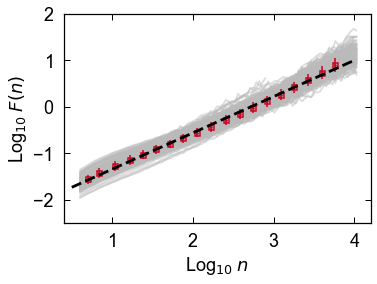

-2.2050136251398675 0.7768068000420008 0.00703823729295


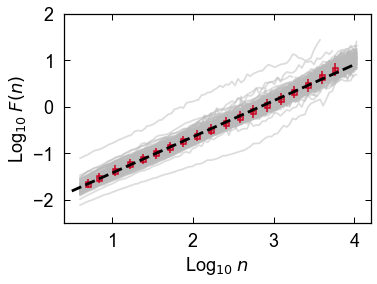

-2.1371839351220756 0.771309522482492 0.00430982315305


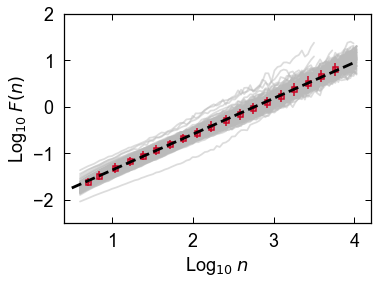

-2.0876329248047187 0.7792836717856465 0.00392672539634


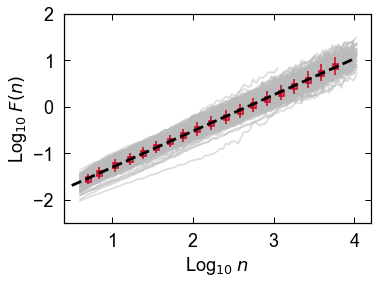

-2.140119588008993 0.7820346087106338 0.00215566397693


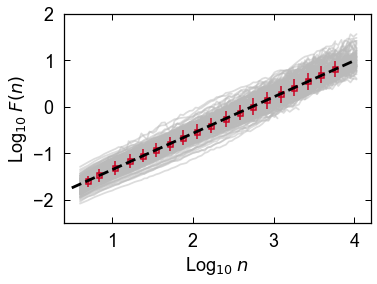

-2.182291658117915 0.8013326973670273 0.00346443997759


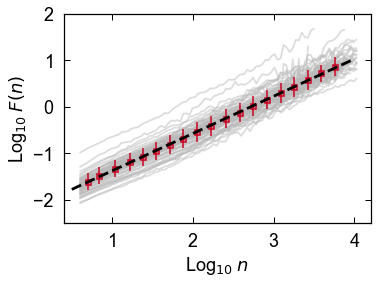

In [302]:
slope_age1=[]
slope_age_error1=[]
for age in range(0,6):
    dataf=dfa_age_list[age].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[:],fw[:])
    intercept, slope = result.params.tolist()
    slope_age1.append(slope)
    slope_age_error1.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5*1.1,3.5*1.1))


    for track in range(0,len(dfa_tracks[age])):
         ax.plot(dfa_tracks[age][track].n,dfa_tracks[age][track].F,color="#bababa",alpha=0.5)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')

    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_ylim(-2.5,2)

#     plt.savefig("../results/fractal_paper/manuscript/dfa/dfa_"+str(column)+"_"+str(age+1)+".pdf",bbox_inches='tight')
    plt.show()

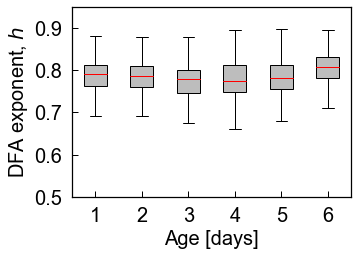

In [255]:
def box_plot_age(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(0.5,0.95)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel('DFA exponent, $h$')
    increase_font(ax,20)    
box_plot_age(age_list_slope,)


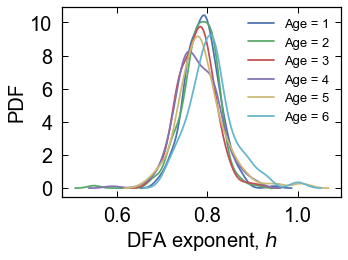

In [258]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(age_list_slope[age],hist=False, rug=False,label="Age = "+str(age+1))

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [259]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(age_list_slope[age], 'norm'))

KstestResult(statistic=0.75518186172554946, pvalue=0.0)
KstestResult(statistic=0.74644232167244839, pvalue=0.0)
KstestResult(statistic=0.74986805093275066, pvalue=0.0)
KstestResult(statistic=0.74064583024326458, pvalue=0.0)
KstestResult(statistic=0.74597427756171519, pvalue=0.0)
KstestResult(statistic=0.76124648631152902, pvalue=0.0)


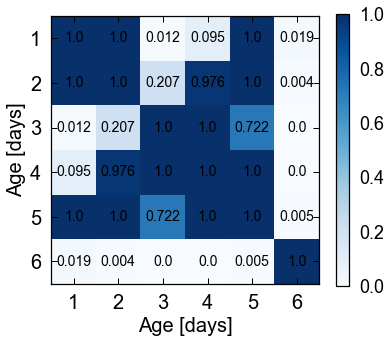

In [260]:
indexes=[]
new_p_age=[]
for j in range(0,6):
    for i in range(0,6):
        s1=[x for x in age_list_slope[j] if str(x) != 'nan']
        s2=[x for x in age_list_slope[i] if str(x) != 'nan']
        tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)

        if i <j:
            new_p_age.append(pvalue)
            indexes.append((i, j))


a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

p_array = np.ones((6, 6))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)

ak=[1,2,3,4,5,6]
p = pd.DataFrame(p_array, index=ak, columns=ak)

p = p.loc[:6, :6]

matrix_plot_age(p)
# plt.savefig('../results/fractal_paper/manuscript/dfa/matrix_'+str("speed")+'.pdf', bbox_inches='tight')

# Temperature data set

## Mean Square Displacement


In [303]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

In [304]:
df_x,df_y=read_tracks(tracks)
variance=msd(df_x,df_y)

In [305]:
var_df=pd.DataFrame(np.transpose([np.arange(0,len(df_y))/5,variance]),columns=["time","variance"])
var_df.to_csv("../results/msd_temperature-{}.csv".format(temperature))
var_df.head()

,time,variance
0,0.0,0.000000
1,0.2,0.000093
2,0.4,0.000422
3,0.6,0.001261
4,0.8,0.002224


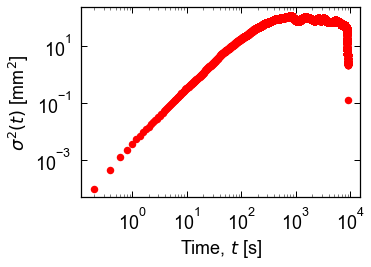

In [306]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
         ylabel="$\sigma^2(t)$ [mm$^2$]")

ax.loglog(np.arange(0,len(df_y))/5,variance, ".r",markersize=15)

increase_font(ax,fontsize=18)

In [312]:
for temperature in [15,20,25]:
    msd_by_temp(temperature)

In [433]:
msd_temp=pd.DataFrame()
temperature=15
df=pd.read_csv("../results/msd_temperature-{}.csv".format(temperature),index_col=0)
msd_temp['time']=df['time']
for temperature in [15,20,25]:
    df=pd.read_csv("../results/msd_temperature-{}.csv".format(temperature),index_col=0)
    msd_temp[str(temperature)]=df['variance']

[ 2.35330532  1.91347626  1.8057729 ]
[ 0.01021964  0.00945762  0.01234775]


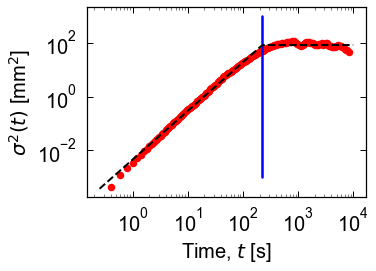

[ 2.11249271  1.82922847  1.83096301]
[ 0.01639883  0.01411331  0.02313206]


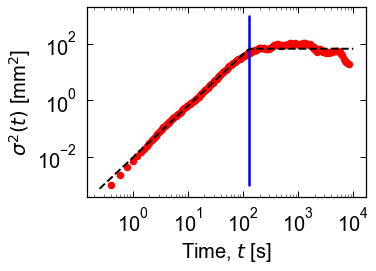

[ 2.23261111  1.75201581  1.80650663]
[ 0.0109549   0.00971492  0.01420025]


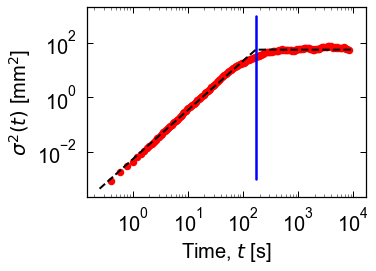

In [436]:
exp=[]
experror=[]
for i in [15,20,25]:
    y=np.log10(msd_temp[str(i)].tolist()[1:])
    x=np.log10(msd_temp["time"].tolist()[1:])
    
    xw, yw=winm(x,y,200)
    xw2, yw2=winm(x,y,1000)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) #x0, y0, k1
    print(p)
    exp.append(p[2])
    experror.append(np.sqrt(np.diag(pcov))[2])

    print(np.sqrt(np.diag(pcov)))
    xd = np.linspace(-0.6, 4, 100)
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
             ylabel="$\sigma^2(t)$ [mm$^2$]")
    locy = plticker.MultipleLocator(base=1^10) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    

    ax.loglog(10**np.array(xw),10**np.array(yw), ".r",markersize=15)
    ax.loglog([10**p[0],10**p[0]],[10**-3,10**3],"-b",linewidth=2.5)
    ax.loglog(10**xd, 10**piecewise_linear(xd, *p),"--k",linewidth=2)

    increase_font(ax,fontsize=20)
    plt.savefig("../results/msd_temp_"+str(i)+".pdf",bbox_inches='tight')
    plt.show()

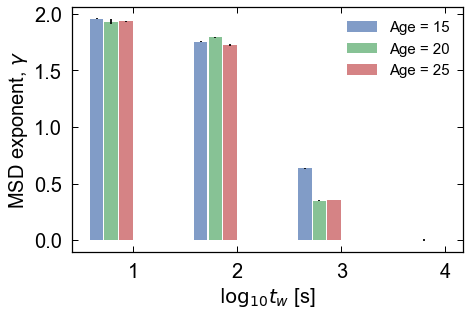

In [438]:
fig, ax = plt.subplots(figsize=(7,4.5))
ax = plt.subplot(111, xlabel="$\log_{10} t_w$ [s]", 
         ylabel="MSD exponent, $\gamma$")

ind = np.arange(4)  # the x locations for the groups
width = 0.13# the width of the bars
ax.set_xticks(ind + 3*(width+0.03))
step=0
for i in [15,20,25]:
   
    df=msd_temp[["time",str(i)]].copy()
    df=df.apply(np.log10)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna()


    experror=[]
    result=[]
    for w in np.arange(1,5,1):
        df2=df[df.time<w].copy()
        if w==0:
            df2=df2
        else:
            df2=df2[df2.time>w-1]

        y=df2[str(i)].tolist()
        x=df2["time"].tolist()

        param_bounds=([0,-np.inf],[2,np.inf])
        popt, pcov = optimize.curve_fit(line, x, y,bounds=param_bounds) 
        result.append([w+i/10,popt[0]])
        experror.append(np.sqrt(np.diag(pcov))[0])


    yerr=np.asarray(experror)
    exp_means=[result[k][1] for k in range(0,4)]


    ax.bar(ind + width+step, exp_means, width, yerr=yerr,alpha=0.7,label="Age = "+str(i))
    step=step+ width+0.01




ax.set_xticklabels(('1', '2', '3','4'))
locy = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)

ax.legend(fontsize=15) 
increase_font(ax,fontsize=20)
plt.savefig("../results/msd_temp_fit.pdf",bbox_inches='tight')

### Bootstrapping


In [ ]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

In [ ]:
data_plot=[]
for t in [15,20,25]:
    df_x,df_y=read_dataset("temperature",t)
    slope_bootstrapping=[]
    for i in range(0,100):
        print(t,i)
        slope=slope_random_sample(df_x,df_y)
        slope_bootstrapping.append(slope)
    data_plot.append(slope_bootstrapping)
    data_plot = pd.DataFrame(data_plot)
    data_plot.to_csv('../results/msd_bootstrapping_{}.csv'.format(t), index=False, header=False)



### Two-sample test

In [428]:
def box_plot_temp(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)


#     for i in range(0,len(data_to_plot)):
#         x=[i+1+np.random.normal(0, 0.05, None) for e in data_to_plot[i] ]
#         y=data_to_plot[i]
#         ax.scatter(x,y,c="red",edgecolor="black", s=25,alpha=0.2)
        
    ax.set_xticklabels(['15', '20','25'])
#     ax.grid()
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

#     ax.set_ylim(bottom_limit,1.0)
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel('MSD exponent, $\gamma$')
    increase_font(ax,18)
    
def matrix_plot_t(conf_arr):
    conf_arr=np.array(conf_arr)


    fig = plt.figure(figsize=(6,5))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=18)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = ["15","20","25"]
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Temperature [°C]',fontsize=20)
    ax.set_ylabel('Temperature [°C]',fontsize=20)
    ax.tick_params(labelsize=20)

In [429]:

indexes=[]
new_p_t=[]
for j in range(0,3):
    for i in range(0,3):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        if i <j:
            new_p_t.append(pvalue)
            indexes.append((i, j))


# Plot p-values with correction for multiple testing    
a, corrected_p, c, d = smm.multipletests(new_p_t, method='b')

p_array = np.ones((3, 3))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[15,20,25]
p = pd.DataFrame(p_array, index=ak, columns=ak)
print(p)


       15     20   25
15  1.000  0.013  0.0
20  0.013  1.000  0.0
25  0.000  0.000  1.0


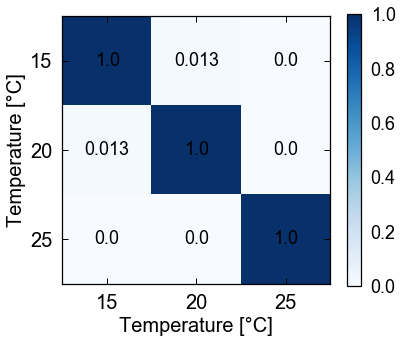

In [430]:
matrix_plot_t(p)

## Fractal dimension


In [322]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [326]:
df=df_tracks[20]

series="mov_forward"

In [327]:
df.head()

,time,x,y,speed,head_speed,mov_forward
8962,1800.0,10.238871,20.885751,0.012713,0.032543,0.0
8963,1800.2,10.239461,20.888503,0.016259,0.075935,0.0
8964,1800.4,10.239992,20.892161,0.021346,0.010848,0.0
8965,1800.6,10.240566,20.895096,0.017278,0.097630,0.0
8966,1800.8,10.241316,20.897688,0.015582,0.032543,0.0


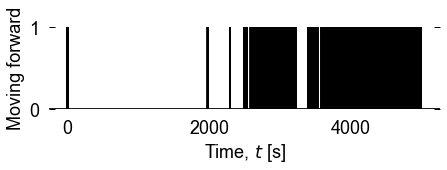

In [328]:
names=["Moving forward"]
fontsize=20
for k in range(0,len(names)):
    gs = gridspec.GridSpec(1,1)
    fig = plt.figure(figsize=(7,1.5))
    
    ax0 = fig.add_subplot(gs[0,0])
    x=np.array(df[["time"]][df.time<5000]).ravel()
    y1=np.array(df[["mov_forward"]][df.time<5000]).ravel()
    ax0.vlines(x, 0, y1, colors='k', linestyles='solid')
    ax0.acorr(x,color='k')
        
    ax0.set_ylim(0,1)
    #ax0.set_xlim(0,2000)
    ax0.locator_params(axis='x',nbins=5)
    ax0.locator_params(axis='y',nbins=1)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    
    ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    
    
    plt.ylabel("Moving forward") ; plt.xlabel('Time, $t$ [s]') ;

    increase_font(ax0,18)
    

0.753226535766 0.00697731946344


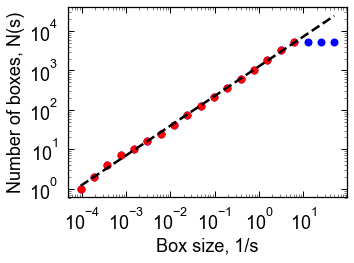

In [329]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df,std_err)
fractal_plot(r,N,A,Df,drop_first_points,drop_last_points,series)
plt.show()

In [330]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df)

0.753226535766


In [331]:
for temperature in [15,20,25]:
    print(temperature)
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]

    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)

    fd_exp=[]
    for track in df_tracks:
        df=track
        series="mov_forward"
        eventtimes = timeseriestoeventtimes(df, series)
        if sum(eventtimes) > 0:
            r, N = nbox_boxsize(eventtimes, number_of_sizes=20)
            if sum(N) > 0:
                list_df, error_df = find_stable_slope(r, N, 3)
                drop_last_points = -(len(np.array(list_df)[np.array(list_df) < 0.1]) + 1)
                drop_first_points = 0
                Df, A, r_value, p_value, std_err = fit_data(
                    r[drop_first_points:drop_last_points],
                    N[drop_first_points:drop_last_points])
                if len(r) > abs(drop_last_points):
                    fd_exp.append(Df)

    data_plot = pd.DataFrame(fd_exp)
    data_plot.to_csv('../results/fd_exp-{}.csv'.format(temperature), index=False, header=False)


15
20
25


In [333]:
df_temperature=pd.DataFrame()

for temp in [15,20,25]:
    df=pd.read_csv('../results/fd_exp-{}.csv'.format(temp),names=[temp])
    df_temperature[temp]=df[temp]

In [338]:
def box_plot_temp(data_to_plot,bottom_limit):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)


#     for i in range(0,len(data_to_plot)):
#         x=[i+1+np.random.normal(0, 0.05, None) for e in data_to_plot[i] ]
#         y=data_to_plot[i]
#         ax.scatter(x,y,c="red",edgecolor="black", s=25,alpha=0.2)
        
    ax.set_xticklabels(['15', '20','25'])
#     ax.grid()
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_ylim(bottom_limit,1.0)
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel('MSD exponent, $\gamma$')
    increase_font(ax,18)
    
def matrix_plot_t(conf_arr):
    conf_arr=np.array(conf_arr)


    fig = plt.figure(figsize=(6,5))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=18)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = ["15","20","25"]
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Temperature [°C]',fontsize=20)
    ax.set_ylabel('Temperature [°C]',fontsize=20)
    ax.tick_params(labelsize=20)

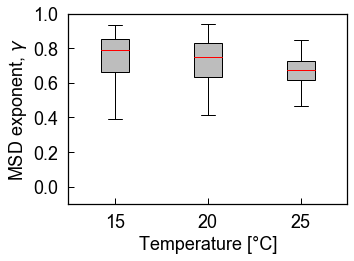

In [339]:
data_to_plot=[list(df_temperature[x].dropna()) for x in list(df_temperature.columns)]
box_plot_temp(data_to_plot,-0.1)
plt.savefig('../results/temperature_fractal_d.pdf', bbox_inches='tight')

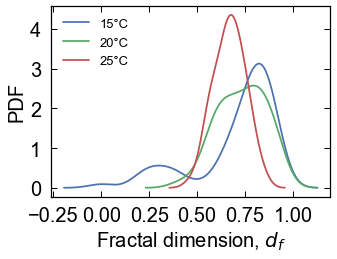

In [343]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for temp in [0,1,2]:
    sns.distplot(data_to_plot[temp],hist=False, rug=False,label=str(temp*5+15)+str("°C"))

    
ax.legend(fontsize=13) 
ax.set_xlabel('Fractal dimension, $d_f$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [344]:
for temp in [0,1,2]:
    print(stats.kstest(data_to_plot[temp], 'norm'))

KstestResult(statistic=0.5600008845455563, pvalue=0.0)
KstestResult(statistic=0.67684562952815674, pvalue=0.0)
KstestResult(statistic=0.68299626335020158, pvalue=0.0)


In [420]:
indexes=[]
new_p_temp=[]
for j in range(0,3):
    for i in range(0,3):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)
        if i <j:
            new_p_temp.append(pvalue)
            indexes.append((i, j))

a, corrected_p, c, d = smm.multipletests(new_p_temp, method='b')

p_array = np.ones((3, 3))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[15,20,25]
p = pd.DataFrame(p_array, index=ak, columns=ak)

#p = p.loc[:3, :3]

In [421]:
p_array

array([[ 1.   ,  0.005,  0.   ],
       [ 0.005,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

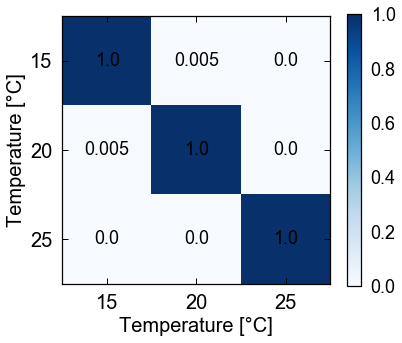

In [422]:
matrix_plot_t(p)

## DFA

In [423]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [360]:
df_tracks[0].head()

,time,x,y,speed,head_speed,mov_forward
8346,1800.0,14.911142,8.752630,0.102395,0.168477,1.0
8347,1800.2,14.934215,8.758602,0.128771,0.178388,1.0
8348,1800.4,14.956489,8.763605,0.123344,0.178388,1.0
8349,1800.6,14.973948,8.766911,0.096008,0.079284,1.0
8350,1800.8,14.992555,8.769965,0.101876,0.009910,1.0


In [361]:
for temperature in [15,20,25]:
    print(temperature)
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]

    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)
    for i in range(0,len(df_tracks)):
        track=df_tracks[i]
        y=np.array(track["speed"])
        df=dfa(y,order=1)
        df.to_csv("../results/dfa/speed-{}-{}.csv".format(temperature,i))
        track=df_tracks[i]
        y=np.array(track["head_speed"])
        df=dfa(y,order=1)
        df.to_csv("../results/dfa/head_speed-{}-{}.csv".format(temperature,i))

15
20
25


### Speed

In [386]:
dfa_temp_tracks=[]
for temperature in [15,20,25]:
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/speed-{}-{}.csv".format(temperature,i))
        temp.append(df)
    dfa_temp_tracks.append(temp)    

In [387]:
dfa_temp_list=[pd.concat(dfa_temp_tracks[t]) for t in [0,1,2]]

-2.706512261692756 0.9244409470714458 0.0153496979697


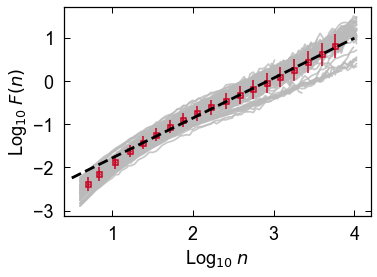

-2.516453261911769 0.904278147302729 0.011999581522


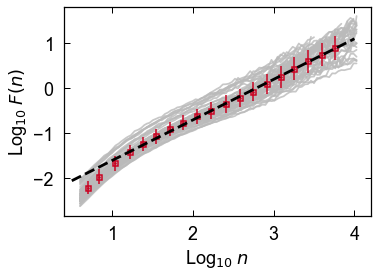

-2.6543985815928686 0.9418798078279615 0.0144598849153


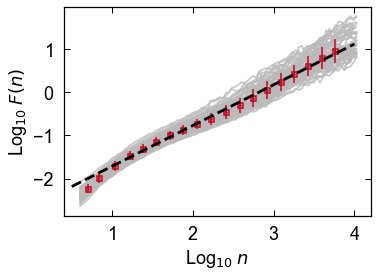

In [388]:

slope_temp=[]
slope_temp_error=[]
for temp in [0,1,2]:
    dataf=dfa_temp_list[temp].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[2:],fw[2:])
    intercept, slope = result.params.tolist()
    slope_temp.append(slope)
    slope_temp_error.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5*1.1,3.5*1.1))


    for track in range(0,len(dfa_temp_tracks[temp])):
         ax.plot(dfa_temp_tracks[temp][track].n,dfa_temp_tracks[temp][track].F,color="#bababa",alpha=0.8)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

#     plt.savefig("../results/fractal_paper/manuscript/dfa/dfa_temp_"+str(column)+"_"+str(temp)+".pdf",bbox_inches='tight')
    plt.show()


In [391]:
temp_list_slope=[]
for t in range(0,3,1):
    temp=[]
    for i in range(0,len(dfa_temp_tracks[t])):
        result=linmodel_fit(dfa_temp_tracks[t][i]["n"],dfa_temp_tracks[t][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    temp_list_slope.append(temp)

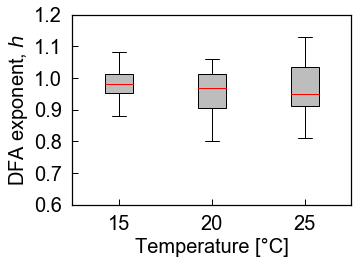

In [392]:
def box_plot_tmp(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['15', '20','25'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(0.6,1.2)
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel('DFA exponent, $h$')
    increase_font(ax,20)
    
box_plot_tmp(temp_list_slope)


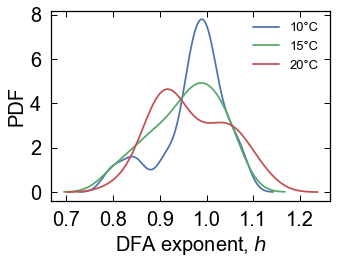

In [393]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(temp_list_slope[t],hist=False, rug=False,label=str(10+t*5)+"°C")

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [395]:
for t in [0,1,2]:
    print(stats.kstest(temp_list_slope[t], 'norm'))

KstestResult(statistic=0.78463123948989466, pvalue=0.0)
KstestResult(statistic=0.78878709959137772, pvalue=0.0)
KstestResult(statistic=0.79082090221249635, pvalue=0.0)


In [424]:
data_to_plot=temp_list_slope
indexes=[]
new_p_temp=[]
for j in range(0,3):
    for i in range(0,3):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)
        if i <j:
            new_p_temp.append(pvalue)
            indexes.append((i, j))

a, corrected_p, c, d = smm.multipletests(new_p_temp, method='b')

p_array = np.ones((3, 3))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[15,20,25]
p = pd.DataFrame(p_array, index=ak, columns=ak)

#p = p.loc[:3, :3]

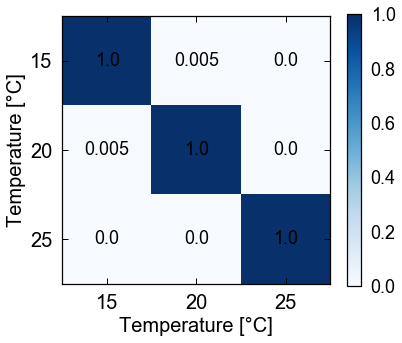

In [425]:
matrix_plot_t(p)


### Head speed 


In [408]:
dfa_tracks=[]
for temperature in [15,20,25]:
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/head_speed-{}-{}.csv".format(temperature,i),index_col=0)
        temp.append(df)
    dfa_tracks.append(temp)

dfa_temp_tracks=dfa_tracks
temp_list_slope=[]
for temperature in [0,1,2]:
    temp=[]
    for i in range(0,len(dfa_tracks[temperature])):
        result=linmodel_fit(dfa_tracks[temperature][i]["n"],dfa_tracks[temperature][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    temp_list_slope.append(temp)

In [403]:
dfa_temp_list=[pd.concat(dfa_tracks[t]) for t in [0,1,2]]

-2.151522342953808 0.7645937238494098 0.00651088222981


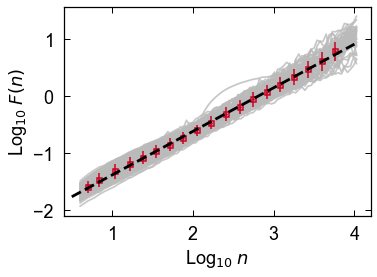

-2.1037951192315156 0.7902772194267813 0.00807797203855


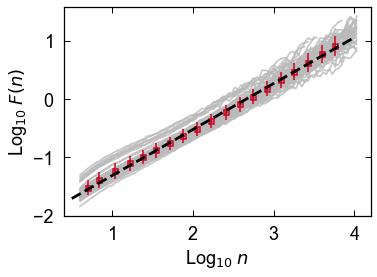

-2.212052944031873 0.8371623679134115 0.0141360509584


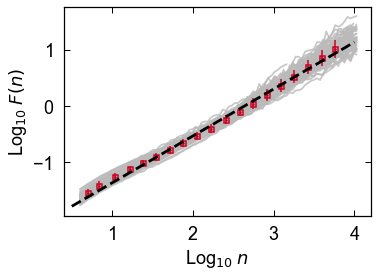

In [404]:

slope_temp=[]
slope_temp_error=[]
for temp in [0,1,2]:
    dataf=dfa_temp_list[temp].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[2:],fw[2:])
    intercept, slope = result.params.tolist()
    slope_temp.append(slope)
    slope_temp_error.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5*1.1,3.5*1.1))


    for track in range(0,len(dfa_temp_tracks[temp])):
         ax.plot(dfa_temp_tracks[temp][track].n,dfa_temp_tracks[temp][track].F,color="#bababa",alpha=0.8)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

#     plt.savefig("../results/fractal_paper/manuscript/dfa/dfa_temp_"+str(column)+"_"+str(temp)+".pdf",bbox_inches='tight')
    plt.show()


In [407]:
temp_list_slope

[]

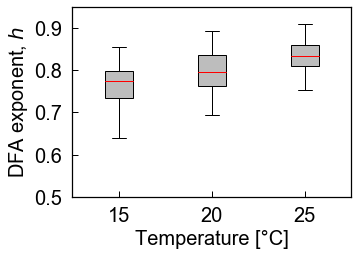

In [412]:
def box_plot_tmp(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['15', '20','25'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(0.5,0.95)
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel('DFA exponent, $h$')
    increase_font(ax,20)
    
box_plot_tmp(temp_list_slope)


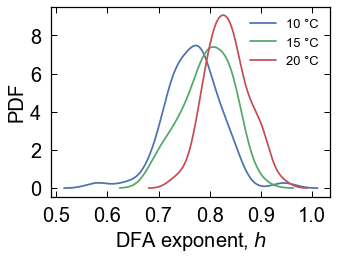

In [415]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(temp_list_slope[t],hist=False, rug=False,label=str(10+t*5)+" °C")

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)

In [417]:
for t in [0,1,2]:
    print(stats.kstest(temp_list_slope[t], 'norm'))

KstestResult(statistic=0.72374638885618015, pvalue=0.0)
KstestResult(statistic=0.75623819672387915, pvalue=0.0)
KstestResult(statistic=0.76784511908350428, pvalue=0.0)


In [426]:
data_to_plot=temp_list_slope
indexes=[]
new_p_temp=[]
for j in range(0,3):
    for i in range(0,3):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        tstat, pvalue=stats.mannwhitneyu(s1,s2)
        if i <j:
            new_p_temp.append(pvalue)
            indexes.append((i, j))

a, corrected_p, c, d = smm.multipletests(new_p_temp, method='b')

p_array = np.ones((3, 3))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[15,20,25]
p = pd.DataFrame(p_array, index=ak, columns=ak)

#p = p.loc[:3, :3]

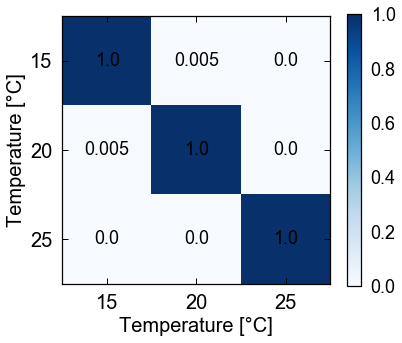

In [427]:
matrix_plot_t(p)